# Aulão LLM's e Agentes - RAG


## Etapa 1 - Chat para responder dúvidas de responsáveis

Vamos construir um RAG simples para responder dúvidas de responsáveis usando como fonte um PDF da escola (ex.: proposta pedagógica, FAQ de matrícula, política de bolsas).

Aqui tem um esquema do RAG, passaremos por cada etapa dessa, que com o Langchain fica bem simples de implementar:

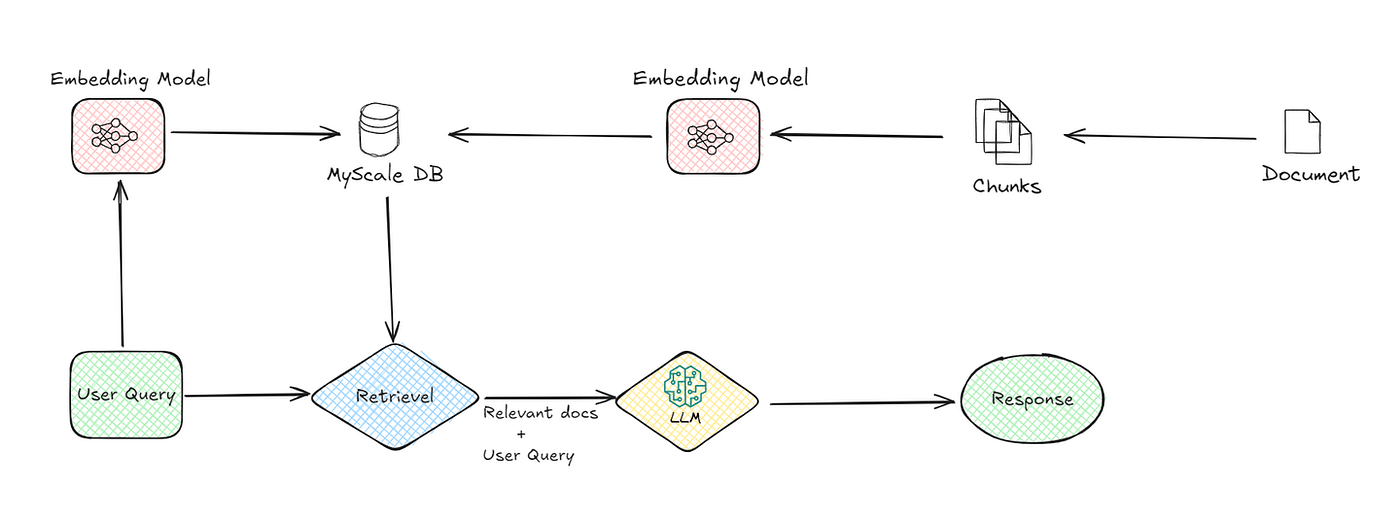


Entretanto, se você quer fazer algo mais robusto, você consegue ter mais "autonomia" e controle do RAG usando o LIama Index. 

Dá uma olhada no *Revista Vanguard.pdf*, sem o RAG teríamos que inputar o conteúdo completo do PDF no prompt, o que não é viável. O que faremos é usar o RAG para buscar os trechos mais relevantes do PDF de acordo com a pergunta do usuário, essa é a magia central dessa técnica.

Tratando do documento, a primeira etapa é transformar o documento em chunks e gerar embeddings para cada chunk.

Cada `Document` tem:

- `page_content`: o texto extraído.
- `metadata`: informações úteis como source (arquivo) e page (página)

A `metadata` é importante para depois podemos(em uma outra situação) referenciar a fonte da informação que o modelo usou para responder a pergunta do usuário.

In [1]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader('Revista Vanguard.pdf') # tem outros tipos de loaders
# isso aqui poderia ser uma lista de loaders
docs = loader.load()

print(f"Páginas carregadas: {len(docs)}\n")
print(f"Metadados da primeira página: \n{docs[0].metadata}")
print(f"\nTrecho do texto: \n{docs[0].page_content[:300]}")

C:\Users\fealp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Páginas carregadas: 9

Metadados da primeira página: 
{'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': 'PyPDF', 'creationdate': '', 'title': 'Revista Vanguard: A Jornada para a Excelência', 'source': 'Revista Vanguard.pdf', 'total_pages': 9, 'page': 0, 'page_label': '1'}

Trecho do texto: 
Revista  Vanguard:  A  Jornada  para  a  Excelência  Descubra  por  que  o  Vanguard  é  a  escolha  certa  para  o  futuro  do  seu  ﬁlho.  
Palavra  do  Fundador:  A  Paixão  que  Transforma  Vidas  Toda  grande  história  começa  com  um  sonho.  A  nossa  nasceu  em  2000,  da  "paixão  pelo  
e


Agora vamos separar o documento em chunks, que são "pedaços de texto" menores gerados a partir do PDF. Em vez de tentar buscar em um PDF inteiro, a gente busca em pedaços que fazem sentido para recuperar.

**O problema é:** qual o tamanho ideal desses chunks? Pensa só, se você quebrar o texto em pedaços muito grandes, a busca pode ficar imprecisa, você vai ter um chunk com assuntos diferentes. Por outro lado, se os pedaços forem muito pequenos, o contexto pode se perder. (Nesse caso, pessoalmente acho melhor errar para cima, chunks maiores, lidar com falta de contexto é evidentemente pior). Controlamos isso com o:

**`chunk_size` (tamanho do chunk):**
- Muito grande: mistura assuntos → recuperação pior
- Muito pequeno: contexto insuficiente → resposta fraca


**Agora outro problema:** como lidar com informações que "atravessam" a fronteira entre chunks? Por exemplo, uma lista que começa no final de um chunk e termina no início do próximo. Se não tivermos cuidado, podemos perder essa informação importante. Então, é interessante ter uma sobreposição entre os chunks. Nesse caso, controlamos com o:

**`chunk_overlap` (sobreposição entre os chunks):**

A galera tem uma regra prática, mas o ideal é você ajustar aos seus documentos:
- `chunk_size`: 800–1200 caracteres (ou ~300–600 tokens)
- `chunk_overlap`: 10–20% do tamanho do chunk



In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=150
)

chunks = splitter.split_documents(docs)

print(f"Total de chunks:{len(chunks)}\n\n")
print(f"\nTrecho do chunk 0:\n{chunks[0].page_content[:500]}")

Total de chunks:23



Trecho do chunk 0:
Revista  Vanguard:  A  Jornada  para  a  Excelência  Descubra  por  que  o  Vanguard  é  a  escolha  certa  para  o  futuro  do  seu  ﬁlho.  
Palavra  do  Fundador:  A  Paixão  que  Transforma  Vidas  Toda  grande  história  começa  com  um  sonho.  A  nossa  nasceu  em  2000,  da  "paixão  pelo  
educar"
 
dos
 
professores
 
Nazareno
 
Oliveira
 
e
 
Herbenni
 
Leitão.
1
 Mais  do  que  um  colégio,  
o
 
Vanguard
 
é
 
a
 
materialização
 
da
 
visão
 
de
 
um
 
dos
 
maiores
 
educadores
 
d


Agora vamos transformar os chubs em *embeddings*, que são representações numéricas do texto que capturam o significado semântico. Usaremos esses embeddings para comparar a similaridade entre a pergunta do usuário e os chunks do documento. 

A ideia é até que simples:
- textos com significado parecido → vetores “próximos”
- textos diferentes → vetores “distantes”

Então a ideia é buscar os vetores no PDF mais próximos aos vetores da pergunta do usuário.


Vamos organizar esses vetores e o texto original em uma base de dados vetorial (vetor store). Existem várias opções, mas para esse exemplo usaremos a FAISS, que é simples.

In [3]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

# usamos o processo de embeddings da OpenAI
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embeddings)

# busca os top 4 chunks mais relevantes
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

In [9]:
pergunta = "Quais informações são sobre matrícula?"
# hits são os chunks (em formato de Document) mais relevantes para a pergunta
hits = retriever.invoke(pergunta)

for i, d in enumerate(hits, 1):
    src = d.metadata.get("source", "desconhecido")
    page = d.metadata.get("page", "??")
    preview = d.page_content.replace("\n", " ")[:300] # até 300 chars só
    print(f"{i}. Fonte: {src} | Página: {page}")
    print(f"Trecho do Hit: {preview}...\n")

1. Fonte: Revista Vanguard.pdf | Página: 4
Trecho do Hit: concurso   funciona   como   uma   avaliação   diagnóstica   e   oferece   bolsas   de   5%   a   70%   para   o   ensino   regular   e   de   5%   a   100%   para   o   pré-vestibular,   com   base   no   desempenho   do   aluno.6   Para   os   pequenos   da   Educação   Infantil   ao   3º   ano,  ...

2. Fonte: Revista Vanguard.pdf | Página: 7
Trecho do Hit: 15.   Veja  as  escolas  particulares  do  ES  com  melhor  desempenho  no  Enem  2024  -  A   Gazeta,   acessado   em   julho   14,   2025,  https://www.agazeta.com.br/es/cotidiano/veja-as-escolas-particulares-do-es-com-melhor-desempenho-no-enem-2024-0725  16.   Metodologia  -  Colégio  Vanguard,  ...

3. Fonte: Revista Vanguard.pdf | Página: 1
Trecho do Hit: 19  das  50  vagas  (38%);  1º  lugar  geral;  maior  número  de  notas  10  em  Redação.   10   2021  Nota  1000  na  Redação  do  ENEM   Conquista  de  nota  máxima  na  redação  do  Exame  Nacional  do  Ensino  Mé

In [15]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

contexto = retriever | RunnableLambda(lambda docs: "\n\n".join(" ".join(d.page_content.split()) for d in docs))

contexto

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000226808B8610>, search_kwargs={'k': 4})
| RunnableLambda(lambda docs: '\n\n'.join((' '.join(d.page_content.split()) for d in docs)))

Ok. Isso foi só para mostrar um pouco o que rola por trás nesse rankeamento.

E agora o ideal é jogar o conteúdo gerado para a LLM formar uma resposta ao usuário. Aqui tem vários jeitos, inclusive pelo Langchain tem formas diferentes, então não se apegue ao exemplo, só a lógica.

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""Você é um atendente de captação escolar.
Responda APENAS com base no CONTEXTO fornecido.
Se o contexto não tiver informação suficiente, diga que não encontrou no material e peça o detalhe necessário.

CONTEXTO:
{contexto}

PERGUNTA:
{pergunta}

RESPOSTA:""",
    input_variables=["contexto", "pergunta"]
)


llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

chain = (
  {
    "contexto": retriever
      | RunnableLambda(lambda docs: "\n\n".join(" ".join(d.page_content.split()) for d in docs)),
    "pergunta": RunnablePassthrough()
  }
  | prompt | llm | StrOutputParser()
)

pergunta = "Me fale sobre a infraestrutura"
resposta = chain.invoke(pergunta)
resposta

'Nossas unidades em Fortaleza são projetadas para oferecer uma experiência educacional completa, com instalações modernas para esportes, artes e tecnologia. A Sede Vanguard Bezerra conta com três quadras poliesportivas cobertas e uma piscina com raias, enquanto a Sede Vanguard Sul possui duas quadras poliesportivas cobertas e uma piscina. Em relação às artes, a Sede Bezerra possui um teatro com capacidade para 400 pessoas, um estúdio de gravação de música e um ateliê de artes visuais totalmente equipado para pintura, escultura e design. Ambas as unidades têm laboratórios de informática com equipamentos modernos e um Clube de Informática, além de bibliotecas com acervo informatizado e acesso à internet. O Planetário Digital Vanguard, localizado na Sede Bezerra, oferece aulas imersivas de Astronomia e outras ciências.'

Essas duas imagens resumem bem o que a gente fez:

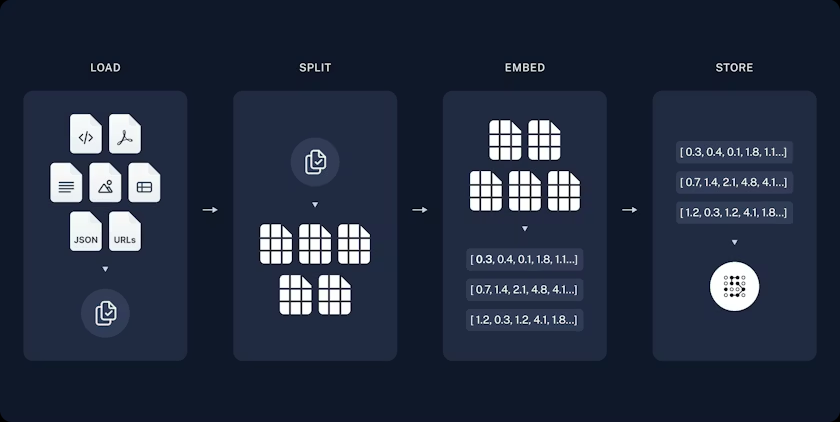

1) **Load**  
Carregamos o conteúdo (PDF) e transformamos em documentos com texto + metadados.

2) **Split**  
Dividimos o texto em **chunks** (pedaços menores) com **overlap** para não perder informações que ficam na “borda” entre dois pedaços.

3) **Transformação em Embeddings**  
Convertimos cada chunk em um **embedding** (vetor numérico) que representa o significado do texto.

4) **Store**  
Guardamos os embeddings em um **banco vetorial** (ex.: FAISS) para permitir busca semântica rápida.


Daí como a busca funciona com essa estrutura montada:

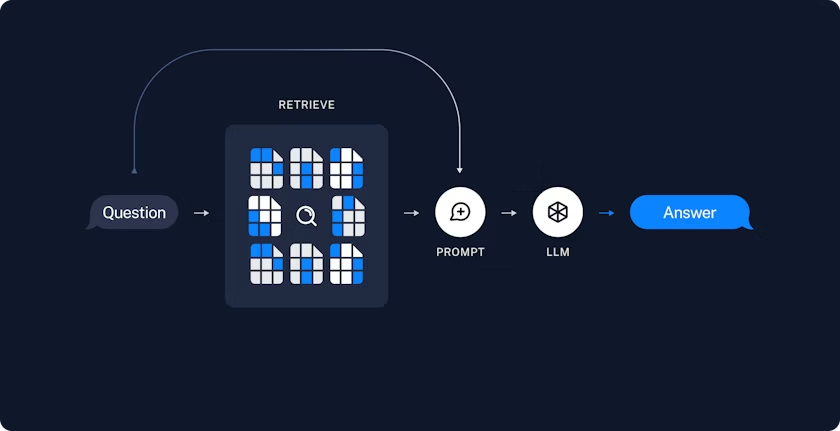

- A pergunta do responsável é usada para buscar os top-k chunks mais similares (ex.: `k=4`).
- Esses chunks viram o contexto do prompt.
- O LLM responde somente com base no contexto (se não encontrar evidência suficiente, pede mais detalhes).

E se em alguma ocasição querermos referenciar a fonte da informação, podemos usar os metadados que guardamos junto com o chunk (ex.: nome do arquivo, página).

In [ ]:
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from typing import List
from pprint import pprint
# colocamos as referencias no contexto
class Resposta(BaseModel):
    resposta: str = Field(description="Texto humano para WhatsApp")
    # aqui seria bizu vc também expandir caso tivesse outros documentos juntos, como só temos um pdf, tanto faz
    fontes: List[str] = Field(description="Lista de fontes no formato arquivo#página (ex: escola.pdf#p3)")

parser = JsonOutputParser(pydantic_object=Resposta)


prompt = PromptTemplate(
    template="""Você é um atendente de captação escolar.
Responda APENAS com base no CONTEXTO fornecido.
Se o contexto não tiver informação suficiente, diga que não encontrou no material e peça o detalhe necessário.

CONTEXTO:
{contexto}

PERGUNTA:
{pergunta}

{format_instructions}""",
    input_variables=["contexto", "pergunta"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

chain = (
  {
    "contexto": retriever
      | RunnableLambda(lambda docs: "\n\n".join(
          f"[{d.metadata.get('source','?')}#p{d.metadata.get('page','?')}] " + " ".join(d.page_content.split())
          for d in docs
      )),
    "pergunta": RunnablePassthrough()
  }
  | prompt
  | llm
  | parser
)

pergunta = "Me fale sobre a infraestrutura"
resposta = chain.invoke(pergunta)
pprint(resposta)

{'fontes': ['Revista Vanguard.pdf#p3', 'Revista Vanguard.pdf#p6'],
 'resposta': 'Nossas unidades em Fortaleza possuem uma infraestrutura moderna '
             'e completa, incluindo três quadras poliesportivas cobertas, '
             'piscina com raias, salas de balé, dança e judô, além de '
             'laboratórios de informática equipados com tecnologia moderna. A '
             'Sede Bezerra conta com um planetário digital de última geração '
             'para aulas imersivas. Também temos um estúdio de gravação de '
             'música e um ateliê de artes visuais totalmente equipado para '
             'pintura, escultura e design.'}
